# Russian River Step 1 -- download and clean raw geometry data

In this section, we choose the basin, the streams to be included in the stream-aligned mesh, and make sure that all are resolved discretely at appropriate length scales for this work.

In [1]:
# these can be turned on for development work
%load_ext autoreload
%autoreload 2

In [2]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [3]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
import shapely
import pandas as pd
import geopandas as gpd
pd.options.display.max_columns = None
import pickle

import watershed_workflow 
import watershed_workflow.config
import watershed_workflow.sources
import watershed_workflow.sources.standard_names as names

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)


## Input: Parameters and other source data

Note, this section will need to be modified for other runs of this workflow in other regions.

In [4]:
# Force Watershed Workflow to pull data from this directory rather than a shared data directory.
# This picks up the Coweeta-specific datasets set up here to avoid large file downloads for 
# demonstration purposes.
#
def splitPathFull(path):
    """
    Splits an absolute path into a list of components such that
    os.path.join(*splitPathFull(path)) == path
    """
    parts = []
    while True:
        head, tail = os.path.split(path)
        if head == path:  # root on Unix or drive letter with backslash on Windows (e.g., C:\)
            parts.insert(0, head)
            break
        elif tail == path:  # just a single file or directory
            parts.insert(0, tail)
            break
        else:
            parts.insert(0, tail)
            path = head
    return parts

cwd = splitPathFull(os.getcwd())
assert cwd[-1] == 'workflow'
cwd = cwd[:-1]

# Note, this directory is where downloaded data will be put as well
data_dir = os.path.join(*(cwd + ['input_data',]))
def toInput(filename):
    return os.path.join(data_dir, filename)

output_dir = os.path.join(*(cwd + ['output_data',]))
output_filenames = dict()
def fromOutput(filename):
    return os.path.join(output_dir, filename)    

def toOutput(role, filename):
    output_filenames[role] = filename
    return fromOutput(filename)

# check output and input dirs exist
if not os.path.isdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir, exist_ok=True)
       

In [5]:
# Set the data directory to the local space to get the locally downloaded files
watershed_workflow.config.setDataDirectory(data_dir)


In [6]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
name = 'RussianRiver'
hucs = ['18010110'] # a list of HUCs to run

# Geometric parameters
# -- parameters to clean and reduce the river network prior to meshing
prune_by_area = 10               # km^2
simplify = 125                   # length scale to target average edge 

# -- mesh triangle refinement control
refine_d0 = 200
refine_d1 = 600

refine_L0 = 125
refine_L1 = 300

refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.default_crs


In [7]:
# set up a dictionary of source objects
#
# Data sources, also called managers, deal with downloading and parsing data files from a variety of online APIs.
sources = watershed_workflow.sources.getDefaultSources()

# log the sources that will be used here
watershed_workflow.sources.logSources(sources)


2025-10-06 14:43:08,610 - root - INFO: Using sources:
2025-10-06 14:43:08,610 - root - INFO: --------------
2025-10-06 14:43:08,610 - root - INFO: HUC: WBD
2025-10-06 14:43:08,611 - root - INFO: hydrography: NHDPlus MR v2.1
2025-10-06 14:43:08,611 - root - INFO: DEM: 3DEP 60m
2025-10-06 14:43:08,611 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-10-06 14:43:08,611 - root - INFO: geologic structure: shapefile: "GLHYMPS.shp"
2025-10-06 14:43:08,611 - root - INFO: land cover: NLCD 2021 L48
2025-10-06 14:43:08,612 - root - INFO: LAI: MODIS
2025-10-06 14:43:08,612 - root - INFO: depth to bedrock: raster: "average_soil_and_sedimentary-deposit_thickness.tif"
2025-10-06 14:43:08,612 - root - INFO: meteorology: AORC v1.1


In [8]:
# get the shape and crs of the shape
print(crs)
watershed_shapes = sources['HUC'].getShapesByID(hucs, out_crs=crs)
print(watershed_shapes.crs)

2025-10-06 14:43:08,676 - root - INFO: fixing column: geometry


EPSG:5070
EPSG:5070


## the Watershed

2025-10-06 14:43:08,765 - root - INFO: Removing holes on 1 polygons
2025-10-06 14:43:08,766 - root - INFO:   -- removed interior
2025-10-06 14:43:08,767 - root - INFO:   -- union
2025-10-06 14:43:08,767 - root - INFO: Parsing 1 components for holes
2025-10-06 14:43:08,767 - root - INFO:   -- complete


<Axes: >

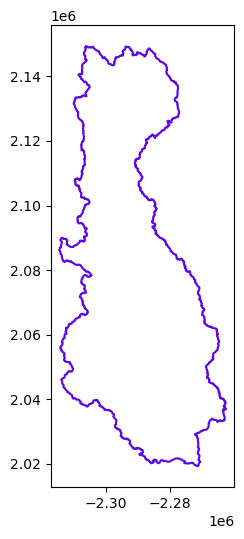

In [9]:
# Construct and plot the WW object used for storing watersheds
watershed = watershed_workflow.split_hucs.SplitHUCs(watershed_shapes)
watershed.plot()

## Gage Data

In [10]:
# find all gages in the river
import pygeohydro

# Initialize NWIS
nwis = pygeohydro.NWIS()
bbox = ','.join(f"{b:.06f}" for b in watershed_shapes.to_crs(watershed_workflow.crs.latlon_crs).geometry[0].bounds)
print(bbox)

query = {
    "bBox": bbox,
    "siteType": "ST",  # stream types
    "parameterCd": "00060,00065", # Discharge and Gage height
    "hasDataTypeCd": "dv",  # Daily values
    "outputDataTypeCd": "dv",  # Output as daily values
}

#
# Fetch all available gages within the bounding box
sites = nwis.get_info(query).to_crs(crs)

#
# Spatial join: keep only sites that fall inside the watershed, not the bounds
sites = gpd.sjoin(sites, watershed_shapes, how="inner", predicate="intersects")

#
# limit to sites with end_date after 2000 -- they MIGHT have good data
sites = sites[sites['end_date'] > '2000-01-01']

sites


-123.387672,38.300252,-122.529502,39.399124


,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,data_type_cd,parm_cd,stat_cd,ts_id,loc_web_ds,medium_grp_cd,parm_grp_cd,srs_id,access_cd,begin_date,end_date,count_nu,hcdn_2009,geometry,index_right,objectid,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,states,huc8,name,globalid,shape_Length,shape_Area,ID,area,huc
73,USGS,11461000,"Russian R Nr Ukiah, CA",ST,39.195447,-123.195005,F,NAD83,602.25,0.16,NAVD88,18010110,dv,00060,00003,11334,,wat,,1645423,0,1911-10-01,2022-09-30,26297,False,POINT (-2295482.376 2127516.678),0,778,{4FE6CEDE-BE3C-4334-837D-45CEBEF4C4A8},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,1723803860000,267200,950359.52,3845.97,CA,18010110,Russian,{83E57CD7-D4E7-440E-A34F-A5411F15742F},620315.002252,6.339680e+09,18010110,3845.97,18010110
77,USGS,11461500,"Ef Russian R Nr Calpella, CA",ST,39.246523,-123.130251,F,NAD83,790.74,0.26,NAVD88,18010110,dv,00010,00001,256189,,wat,,1645597,0,2019-10-31,2025-10-06,2168,False,POINT (-2288553.998 2131447.111),0,778,{4FE6CEDE-BE3C-4334-837D-45CEBEF4C4A8},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,1723803860000,267200,950359.52,3845.97,CA,18010110,Russian,{83E57CD7-D4E7-440E-A34F-A5411F15742F},620315.002252,6.339680e+09,18010110,3845.97,18010110
79,USGS,11461500,"Ef Russian R Nr Calpella, CA",ST,39.246523,-123.130251,F,NAD83,790.74,0.26,NAVD88,18010110,dv,00010,00002,256181,,wat,,1645597,0,2019-10-31,2025-10-06,2168,False,POINT (-2288553.998 2131447.111),0,778,{4FE6CEDE-BE3C-4334-837D-45CEBEF4C4A8},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,1723803860000,267200,950359.52,3845.97,CA,18010110,Russian,{83E57CD7-D4E7-440E-A34F-A5411F15742F},620315.002252,6.339680e+09,18010110,3845.97,18010110
81,USGS,11461500,"Ef Russian R Nr Calpella, CA",ST,39.246523,-123.130251,F,NAD83,790.74,0.26,NAVD88,18010110,dv,00010,00003,256182,,wat,,1645597,0,2019-11-01,2025-10-05,2166,False,POINT (-2288553.998 2131447.111),0,778,{4FE6CEDE-BE3C-4334-837D-45CEBEF4C4A8},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,1723803860000,267200,950359.52,3845.97,CA,18010110,Russian,{83E57CD7-D4E7-440E-A34F-A5411F15742F},620315.002252,6.339680e+09,18010110,3845.97,18010110
82,USGS,11461500,"Ef Russian R Nr Calpella, CA",ST,39.246523,-123.130251,F,NAD83,790.74,0.26,NAVD88,18010110,dv,00010,00008,256183,,wat,,1645597,0,2019-11-01,2025-10-05,2163,False,POINT (-2288553.998 2131447.111),0,778,{4FE6CEDE-BE3C-4334-837D-45CEBEF4C4A8},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,1723803860000,267200,950359.52,3845.97,CA,18010110,Russian,{83E57CD7-D4E7-440E-A34F-A5411F15742F},620315.002252,6.339680e+09,18010110,3845.97,18010110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,USGS,11471000,"Potter Valley Ph Intake Nr Potter Valley, CA",ST,39.366552,-123.127505,F,NAD83,NaN,NaN,,18010110,dv,00060,00003,217373,,wat,,1645423,0,1909-12-01,2024-09-30,41943,False,POINT (-2284540.639 2144288.887),0,778,{4FE6CEDE-BE3C-4334-837D-45CEBEF4C4A8},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,1723803860000,267200,950359.52,3845.97,CA,18010110,Russian,{83E57CD7-D4E7-440E-A34F-A5411F15742F},620315.002252,6.339680e+09,18010110,3845.97,18010110
331,USGS,11471099,"Potter Valley Ph (Tr Only) Nr Potter Valley, CA",ST,39.361552,-123.128338,F,NAD83,NaN,NaN,,18010110,dv,00060

In [11]:
#
# do they actually have data?  download discharge
#
dates = ('2000-01-01', '2026-01-01')
qobs = nwis.get_streamflow(sites.site_no.to_list(), dates, mmd=True)
qobs

,USGS-11461000,USGS-11461500,USGS-11462000,USGS-11462080,USGS-11462500,USGS-11463000,USGS-11463170,USGS-11463200,USGS-11463500,USGS-11463682,USGS-11463900,USGS-11463980,USGS-11464000,USGS-11465000,USGS-11465200,USGS-11465240,USGS-11465350,USGS-11465390,USGS-11465500,USGS-11465660,USGS-11465680,USGS-11465690,USGS-11465700,USGS-11465750,USGS-11466065,USGS-11466170,USGS-11466200,USGS-11466320,USGS-11466800,USGS-11467000,USGS-11467200,USGS-11471000,USGS-11471099,USGS-11471100,USGS-11471105,USGS-11471106
2000-01-01 08:00:00+00:00,0.103029,1.055306,1.850738,NaN,0.585706,0.458129,0.329714,0.254581,NaN,NaN,NaN,0.323633,0.310234,0.866584,0.806223,NaN,0.594600,NaN,NaN,NaN,0.010417,NaN,NaN,0.255591,NaN,NaN,NaN,0.098092,NaN,0.314877,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 08:00:00+00:00,0.103029,0.834194,1.850738,NaN,0.580568,0.454389,0.322546,0.254581,NaN,NaN,NaN,0.320051,0.305479,0.866584,0.806223,NaN,0.590129,NaN,NaN,NaN,0.010417,NaN,NaN,0.267209,NaN,NaN,NaN,0.095670,NaN,0.312053,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03 08:00:00+00:00,0.093662,0.854295,1.833112,NaN,0.577999,0.452519,0.308211,0.254581,NaN,NaN,NaN,0.316468,0.300725,0.779926,0.730821,NaN,0.585659,NaN,NaN,NaN,0.010200,NaN,NaN,0.267209,NaN,NaN,NaN,0.090826,NaN,0.309229,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04 08:00:00+00:00,0.103029,0.874396,1.815486,NaN,0.583137,0.452519,0.315378,0.254581,NaN,NaN,NaN,0.311691,0.298348,0.606609,0.516215,NaN,0.473892,NaN,NaN,NaN,0.010417,NaN,NaN,0.278826,NaN,NaN,NaN,0.090826,NaN,0.296521,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05 08:00:00+00:00,0.112395,0.854295,1.815486,NaN,0.588275,0.454389,0.315378,0.265650,NaN,NaN,NaN,0.308109,0.298348,0.563280,0.464013,NaN,0.402361,NaN,NaN,NaN,0.010634,NaN,NaN,0.302062,NaN,NaN,NaN,0.090826,NaN,0.285931,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-01 07:00:00+00:00,NaN,0.219102,NaN,0.649676,0.526621,0.373983,0.115400,0.069954,0.265915,0.249616,0.039121,0.214960,0.212766,NaN,NaN,0.618956,0.527540,0.256095,NaN,NaN,0.020618,NaN,NaN,0.000581,NaN,NaN,NaN,0.066969,0.004457,0.130610,0.072198,NaN,NaN,NaN,NaN,NaN
2025-10-02 07:00:00+00:00,NaN,0.202016,NaN,0.583719,0.475244,0.355284,0.100348,0.063092,0.264477,0.253753,0.039121,0.218542,0.216332,NaN,NaN,0.618956,0.518598,0.259753,NaN,0.009096,0.022571,NaN,NaN,0.001278,NaN,0.003833,0.028796,0.071934,0.015340,0.134846,0.064724,NaN,NaN,NaN,NaN,NaN
2025-10-03 07:00:00+00:00,NaN,0.176889,NaN,0.540847,0.436710,0.330975,0.085295,0.059550,0.245792,0.239962,0.031168,0.212571,0.210389,NaN,NaN,0.613574,0.514128,0.257010,NaN,0.004548,0.008898,NaN,NaN,0.001743,NaN,0.002556,0.019091,0.035725,0.022694,0.141200,0.050374,NaN,NaN,NaN,NaN,NaN
2025-10-04 07:00:00+00:00,NaN,0.189955,NaN,0.527656,0.431573,0.321625,0.079561,0.054348,0.228543,0.226171,0.027729,0.201823,0.199691,NaN,NaN,0.613574,0.514128,0.246034,NaN,NaN,0.007379,NaN,NaN,0.001975,NaN,0.002130,0.014000,0.026037,0.015860,0.136964,0.042751,NaN,NaN,NaN,NaN,NaN


In [12]:
#
# 36 have data... how many have lots of data?  Lets say at least 10 years of daily data since 2000...
#
qobs_10yrs_k = [k for k in qobs.keys() if qobs[k].count() > 10*365]
len(qobs_10yrs_k)

# these are the 24 that we will mesh into the domain...
qobs_10yrs = qobs[qobs_10yrs_k]
qobs_10yrs

,USGS-11461000,USGS-11461500,USGS-11462000,USGS-11462080,USGS-11462500,USGS-11463000,USGS-11463170,USGS-11463200,USGS-11463500,USGS-11463682,USGS-11463900,USGS-11463980,USGS-11464000,USGS-11465000,USGS-11465200,USGS-11465240,USGS-11465350,USGS-11465680,USGS-11465750,USGS-11466170,USGS-11466200,USGS-11466320,USGS-11466800,USGS-11467000,USGS-11467200
2000-01-01 08:00:00+00:00,0.103029,1.055306,1.850738,NaN,0.585706,0.458129,0.329714,0.254581,NaN,NaN,NaN,0.323633,0.310234,0.866584,0.806223,NaN,0.594600,0.010417,0.255591,NaN,NaN,0.098092,NaN,0.314877,NaN
2000-01-02 08:00:00+00:00,0.103029,0.834194,1.850738,NaN,0.580568,0.454389,0.322546,0.254581,NaN,NaN,NaN,0.320051,0.305479,0.866584,0.806223,NaN,0.590129,0.010417,0.267209,NaN,NaN,0.095670,NaN,0.312053,NaN
2000-01-03 08:00:00+00:00,0.093662,0.854295,1.833112,NaN,0.577999,0.452519,0.308211,0.254581,NaN,NaN,NaN,0.316468,0.300725,0.779926,0.730821,NaN,0.585659,0.010200,0.267209,NaN,NaN,0.090826,NaN,0.309229,NaN
2000-01-04 08:00:00+00:00,0.103029,0.874396,1.815486,NaN,0.583137,0.452519,0.315378,0.254581,NaN,NaN,NaN,0.311691,0.298348,0.606609,0.516215,NaN,0.473892,0.010417,0.278826,NaN,NaN,0.090826,NaN,0.296521,NaN
2000-01-05 08:00:00+00:00,0.112395,0.854295,1.815486,NaN,0.588275,0.454389,0.315378,0.265650,NaN,NaN,NaN,0.308109,0.298348,0.563280,0.464013,NaN,0.402361,0.010634,0.302062,NaN,NaN,0.090826,NaN,0.285931,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-01 07:00:00+00:00,NaN,0.219102,NaN,0.649676,0.526621,0.373983,0.115400,0.069954,0.265915,0.249616,0.039121,0.214960,0.212766,NaN,NaN,0.618956,0.527540,0.020618,0.000581,NaN,NaN,0.066969,0.004457,0.130610,0.072198
2025-10-02 07:00:00+00:00,NaN,0.202016,NaN,0.583719,0.475244,0.355284,0.100348,0.063092,0.264477,0.253753,0.039121,0.218542,0.216332,NaN,NaN,0.618956,0.518598,0.022571,0.001278,0.003833,0.028796,0.071934,0.015340,0.134846,0.064724
2025-10-03 07:00:00+00:00,NaN,0.176889,NaN,0.540847,0.436710,0.330975,0.085295,0.059550,0.245792,0.239962,0.031168,0.212571,0.210389,NaN,NaN,0.613574,0.514128,0.008898,0.001743,0.002556,0.019091,0.035725,0.022694,0.141200,0.050374
2025-10-04 07:00:00+00:00,NaN,0.189955,NaN,0.527656,0.431573,0.321625,0.079561,0.054348,0.228543,0.226171,0.027729,0.201823,0.199691,NaN,NaN,0.613574,0.514128,0.007379,0.001975,0.002130,0.014000,0.026037,0.015860,0.136964,0.042751


In [13]:
#
# create a new sites dataframe, that just has the metadata of continuous sites, and not repeated site_nos associated with different ranges
#
geom = [shapely.geometry.Point(qobs_10yrs.attrs[k]['dec_long_va'], qobs_10yrs.attrs[k]['dec_lat_va']) for k in qobs_10yrs.keys()] 
sites_10yrs = gpd.GeoDataFrame(geometry=geom, crs=watershed_workflow.crs.latlon_crs)

cols = qobs_10yrs.attrs[list(qobs_10yrs.keys())[0]].keys()
for col in cols:
    vals = [qobs_10yrs.attrs[k][col] for k in qobs_10yrs.keys()]
    sites_10yrs[col] = vals    

sites_10yrs['ID'] = list(qobs_10yrs.keys())
sites_10yrs['count'] = [qobs_10yrs[k].count() for k in qobs_10yrs.keys()]
sites_10yrs = sites_10yrs.to_crs(crs)
sites_10yrs

,geometry,station_nm,dec_lat_va,dec_long_va,alt_va,alt_acy_va,alt_datum_cd,huc_cd,begin_date,end_date,units,tz,ID,count
0,POINT (-2295482.62 2127517.048),"Russian R Nr Ukiah, CA",39.195447,-123.195005,602.25,0.16,NAVD88,18010110,1911-10-01,2022-09-30,mm/day,UTC,USGS-11461000,7200
1,POINT (-2288554.228 2131447.502),"Ef Russian R Nr Calpella, CA",39.246523,-123.130251,790.74,0.26,NAVD88,18010110,1941-10-01,2025-10-05,mm/day,UTC,USGS-11461500,9410
2,POINT (-2294805.415 2127544.965),"Ef Russian R Nr Ukiah, CA",39.197391,-123.187505,614.41,0.01,NGVD29,18010110,1911-09-01,2011-10-01,mm/day,UTC,USGS-11462000,4292
3,POINT (-2297109.406 2118353.355),"Russian R Nr Talmage, CA",39.112913,-123.183028,545.95,0.16,NAVD88,18010110,2009-08-06,2025-10-05,mm/day,UTC,USGS-11462080,5905
4,POINT (-2295520.729 2107795.032),"Russian R Nr Hopland, CA",39.026527,-123.130525,500.01,0.26,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11462500,9410
5,POINT (-2293821.342 2090102.265),"Russian R Nr Cloverdale, CA",38.879308,-123.053577,374.64,0.16,NAVD88,18010110,1951-08-01,2025-10-05,mm/day,UTC,USGS-11463000,9410
6,POINT (-2275647.163 2075276.831),"Big Sulphur C A G Resort Nr Cloverdale, CA",38.797645,-122.802458,1429.88,0.16,NAVD88,18010110,1980-10-01,2025-10-05,mm/day,UTC,USGS-11463170,9410
7,POINT (-2290821.963 2082997.741),"Big Sulphur C Nr Cloverdale, CA",38.825976,-122.996908,302.75,0.16,NAVD88,18010110,1957-07-01,2025-10-05,mm/day,UTC,USGS-11463200,7428
8,POINT (-2286019.829 2068367.397),"Russian R A Geyserville, CA",38.712645,-122.895792,165.68,0.26,NAVD88,18010110,1910-10-01,2025-10-05,mm/day,UTC,USGS-11463500,4545
9,POINT (-2282227.758 2060911.556),"Russian R A Jimtown, CA",38.658202,-122.829401,143.70,0.26,NAVD88,18010110,2009-07-01,2025-10-05,mm/day,UTC,USGS-11463682,5276


In [14]:
import pynhd
nldi = pynhd.NLDI()

features = nldi.getfeature_byid("nwissite", sites_10yrs['ID'])

# pull a few things over from the nwis data
sites_10yrs['comid'] = features['comid'].astype(int)
sites_10yrs['measure'] = features['measure'] # in % of total length, the distance up the reach from the downstream point to the gage
sites_10yrs

,geometry,station_nm,dec_lat_va,dec_long_va,alt_va,alt_acy_va,alt_datum_cd,huc_cd,begin_date,end_date,units,tz,ID,count,comid,measure
0,POINT (-2295482.62 2127517.048),"Russian R Nr Ukiah, CA",39.195447,-123.195005,602.25,0.16,NAVD88,18010110,1911-10-01,2022-09-30,mm/day,UTC,USGS-11461000,7200,8269099,42.3900
1,POINT (-2288554.228 2131447.502),"Ef Russian R Nr Calpella, CA",39.246523,-123.130251,790.74,0.26,NAVD88,18010110,1941-10-01,2025-10-05,mm/day,UTC,USGS-11461500,9410,8269091,93.5630
2,POINT (-2294805.415 2127544.965),"Ef Russian R Nr Ukiah, CA",39.197391,-123.187505,614.41,0.01,NGVD29,18010110,1911-09-01,2011-10-01,mm/day,UTC,USGS-11462000,4292,8269105,76.6140
3,POINT (-2297109.406 2118353.355),"Russian R Nr Talmage, CA",39.112913,-123.183028,545.95,0.16,NAVD88,18010110,2009-08-06,2025-10-05,mm/day,UTC,USGS-11462080,5905,8268521,11.7142
4,POINT (-2295520.729 2107795.032),"Russian R Nr Hopland, CA",39.026527,-123.130525,500.01,0.26,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11462500,9410,8269119,91.8680
5,POINT (-2293821.342 2090102.265),"Russian R Nr Cloverdale, CA",38.879308,-123.053577,374.64,0.16,NAVD88,18010110,1951-08-01,2025-10-05,mm/day,UTC,USGS-11463000,9410,8271445,82.7127
6,POINT (-2275647.163 2075276.831),"Big Sulphur C A G Resort Nr Cloverdale, CA",38.797645,-122.802458,1429.88,0.16,NAVD88,18010110,1980-10-01,2025-10-05,mm/day,UTC,USGS-11463170,9410,8271917,32.4839
7,POINT (-2290821.963 2082997.741),"Big Sulphur C Nr Cloverdale, CA",38.825976,-122.996908,302.75,0.16,NAVD88,18010110,1957-07-01,2025-10-05,mm/day,UTC,USGS-11463200,7428,8271875,76.1110
8,POINT (-2286019.829 2068367.397),"Russian R A Geyserville, CA",38.712645,-122.895792,165.68,0.26,NAVD88,18010110,1910-10-01,2025-10-05,mm/day,UTC,USGS-11463500,4545,8272107,28.1658
9,POINT (-2282227.758 2060911.556),"Russian R A Jimtown, CA",38.658202,-122.829401,143.70,0.26,NAVD88,18010110,2009-07-01,2025-10-05,mm/day,UTC,USGS-11463682,5276,8272211,90.8312


In [15]:
# check that no two gages are on the same reach -- this would break our subdomain decomposition
assert len(set(sites_10yrs.comid.tolist())) == len(sites_10yrs)

In [16]:
# check if there are pairs of points that are super close

def checkTooClose(pts, geom='geometry'):
    pairs_dist = []
    pairs_comid = []
    threshold = 1000 # m
    
    for i, geom1 in enumerate(pts[geom]):
        for j, geom2 in enumerate(pts[geom]):
            if i < j:
                d = geom1.distance(geom2)
                if d <= threshold:
                    pairs_dist.append((pts.index[i], pts.index[j], d))
    
                if pts.iloc[i].comid == pts.iloc[j].comid:
                    pairs_comid.append((pts.index[i], pts.index[j], pts.iloc[j].comid))
    
    print('Close pairs:')
    for i,j,d in pairs_dist:
        print(f'point {i} ({pts.loc[i, geom]}) and point {j} {pts.loc[j,geom]}) are within {d} m')
    
    print('Shared comid:')
    for i,j,c in pairs_comid:
        print(f'point {i} ({pts.loc[i, geom]}) and point {j} {pts.loc[j,geom]}) share comid {c}')
    return pairs_dist, pairs_comid

pairs_dist, _ = checkTooClose(sites_10yrs)

Close pairs:
point 0 (POINT (-2295482.6201896165 2127517.04764252)) and point 2 POINT (-2294805.415497692 2127544.9647835977)) are within 677.7798769000635 m
Shared comid:


In [17]:
# lets remove the one with fewer records:
for i,j,d in pairs_dist:
    fewer = i if sites_10yrs.loc[i, 'count'] < sites_10yrs.loc[j, 'count'] else j

sites_10yrs = sites_10yrs.drop(fewer)

In [18]:
#
# After going through this once, two other gages -- 
#   USGS-11463980
#   USGS-11464000
# are rather close to each other, and result in a small subcatchment between them, where the 
# subcatchments downstream of 11464000 and upstream of 11463980 touch each other on either
# side of the small subcatchment, which breaks the partitioning algorithm.
#
# We'll remove the upstream one, as it has fewer records.
sites_10yrs = sites_10yrs[sites_10yrs['ID'] != 'USGS-11463980']


## the Rivers 

In [19]:
# download/collect the river network within that shape's bounds
reaches = sources['hydrography'].getShapesByGeometry(watershed.df, out_crs=crs)

# remove coastlines
reaches = reaches[reaches.ftype != 'Coastline']
print(reaches.crs)

# construct rivers
rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')
print(rivers[0].df.crs)

reaches

/home/ecoon/code/watershed_workflow/repos/master/watershed_workflow/sources/manager_hyriver.py:111: UserWarning: 14 of 1624 requests failed.. IDs of the failed requests are ['8272731', '8272215', '8267989', '8270561', '8272029', '8272961', '8272667', '8270833', '8272017', '8272727', '8272969', '8268253', '8272689', '8272671']
  df = protocol.byid(self._id_name, ids)
2025-10-06 14:43:14,505 - root - INFO: fixing column: geometry
2025-10-06 14:43:14,556 - root - INFO: fixing column: catchment


EPSG:5070
EPSG:5070


,geometry,comid,fdate,resolution,gnis_id,reachcode,flowdir,wbareacomi,ftype,fcode,shape_length,streamleve,streamcalc,fromnode,tonode,levelpathi,pathlength,terminalpa,arbolatesu,startflag,terminalfl,dnlevel,uplevelpat,dnlevelpat,dnminorhyd,dndraincou,frommeas,tomeas,rtndiv,vpuin,vpuout,divdasqkm,tidal,totma,wbareatype,pathtimema,hwnodesqkm,maxelevraw,minelevraw,maxelevsmo,minelevsmo,slope,elevfixed,hwtype,slopelenkm,qa_ma,va_ma,qc_ma,vc_ma,qe_ma,ve_ma,qa_01,va_01,qc_01,vc_01,qe_01,ve_01,qa_02,va_02,qc_02,vc_02,qe_02,ve_02,qa_03,va_03,qc_03,vc_03,qe_03,ve_03,qa_04,va_04,qc_04,vc_04,qe_04,ve_04,qa_05,va_05,qc_05,vc_05,qe_05,ve_05,qa_06,va_06,qc_06,vc_06,qe_06,ve_06,qa_07,va_07,qc_07,vc_07,qe_07,ve_07,qa_08,va_08,qc_08,vc_08,qe_08,ve_08,qa_09,va_09,qc_09,vc_09,qe_09,ve_09,qa_10,va_10,qc_10,vc_10,qe_10,ve_10,qa_11,va_11,qc_11,vc_11,qe_11,ve_11,qa_12,va_12,qc_12,vc_12,qe_12,ve_12,lakefract,surfarea,rareahload,rpuid,vpuid,enabled,gridcode,featureid,sourcefc,shape_length_ca,shape_area,catchment_area,ID,name,length,stream_order,drainage_area_sqkm,catchment,hydroseq,uphydroseq,dnhydroseq,divergence
2,"LINESTRING (-2286593.534 2147538.334, -2286812...",8267665,1999-07-15T04:00:00Z,Medium,,18010110000844,With Digitized,0,StreamRiver,46006,0.002628,4,1,10109046.0,10032459.0,10124013.0,195.712,10006855.0,0.224,1,0,3,0.0,10046826.0,0.0,1,0.00000,100.00000,0,0,0,0.4500,0,0.010756,,138.971019,0.4491,54487.0,52571.0,54487.0,52571.0,0.258919,0,H,0.074,0.392,0.82847,0.155,0.79081,0.155,0.79081,0.925,1.12885,0.907,1.54108,0.907,1.54108,1.023,1.17392,0.646,1.33782,0.646,1.33782,0.980,1.15440,0.370,1.07413,0.370,1.07413,0.546,0.92852,0.179,0.82914,0.179,0.82914,0.274,0.73840,0.055,0.58668,0.055,0.58668,0.133,0.60134,0.045,0.55855,0.045,0.55855,0.066,0.51033,0.029,0.50650,0.029,0.50650,0.036,0.45475,0.009,0.41482,0.009,0.41482,0.024,0.42640,0.016,0.45285,0.016,0.45285,0.030,0.44125,0.011,0.42679,0.011,0.42679,0.096,0.55478,0.093,0.67620,0.093,0.67620,0.570,0.94285,0.736,1.41165,0.736,1.41165,NaN,NaN,NaN,18c,18,1,1382528.0,8267665.0,NHDFlowline,0.033713,0.000047,0.4500,8267665,,0.224,1,0.4500,"POLYGON ((-2286795.015 2147564.952, -2286767.8...",10124013.0,0.0,10083572.0,0
3,"LINESTRING (-2286449.999 2148241.995, -2286448...",8267667,1999-07-15T04:00:00Z,Medium,266519,18010110000843,With Digitized,0,StreamRiver,46006,0.007895,3,1,10109047.0,10032459.0,10046826.0,195.712,10006855.0,0.827,1,0,3,0.0,10046826.0,0.0,1,0.00000,100.00000,0,0,0,0.7128,0,0.037847,,138.971019,0.2556,66846.0,51281.0,66846.0,52571.0,0.211169,0,H,0.676,0.623,0.86815,0.259,0.82974,0.259,0.82974,1.473,1.19238,1.427,1.59861,1.427,1.59861,1.627,1.24031,1.040,1.39910,1.040,1.39910,1.559,1.21942,0.615,1.13359,0.615,1.13359,0.865,0.97471,0.301,0.87304,0.301,0.87304,0.432,0.76925,0.098,0.61957,0.098,0.61957,0.210,0.62261,0.078,0.58405,0.078,0.58405,0.105,0.52585,0.048,0.52140,0.048,0.52140,0.057,0.46561,0.015,0.42325,0.015,0.42325,0.038,0.43515,0.027,0.46532,0.027,0.46532,0.047,0.45030,0.019,0.43861,0.019,0.43861,0.156,0.57673,0.152,0.70124,0.152,0.70124,0.905,0.99090,1.127,1.44664,1.127,1.44664,NaN,NaN,NaN,18c,18,1,1382581.0,8267667.0,NHDFlowline,0.040906,0.000075,0.7128,8267667,Busch Creek,0.827,1,0.7128,"POLYGON ((-2286795.015 2147564.952, -2286938.1...",10124012.0,0.0,10083572.0,0
4,"LINESTRING (-2293081.91 2148733.55, -2292983.6...",8267669,1999-07-15T04:00:00Z,Medium,267200,18010110000227,With Digitized,0,StreamRiver,46003,0.008513,1,1,10109048.0,10032461.0,10006855.0,184.519,10006855.0,0.867,1,0,1,0.0,10006855.0,0.0,1,0.00000,100.00000,0,0,0,1.0179,0,0.038179,,4.415388,0.3960,53217.0,40400.0,53217.0,40715.0,0.173880,0,H,0.719,0.977,0.90190,0.426,0.86331,0.426,0.86331,2.323,1.24848,2.223,1.64265,2.223,1.64265,2.571,1.30051,1.661,1.45136,1.661,1.45136,2.422,1.26955,0.995,1.17908,0.995,1.17908,1.362,1.01641,0.501,0.91321,0.501,0.91321,0.688,0.80106,0.173,0.65228,0.173,0.65228,0.333,0.64352,0.135,0.60985,0.135,0.60985,0.167,0.54070,0.079,0.53520,0.079,0.53520,0.085,0.47069,0.023,0.42618,

In [20]:
#
# are all of our gage-reaches in the set of reaches?
print(sum(sites_10yrs['comid'].isin(reaches['comid'])), ' of ', len(sites_10yrs), ' are in the set of ALL reaches')

23  of  23  are in the set of ALL reaches


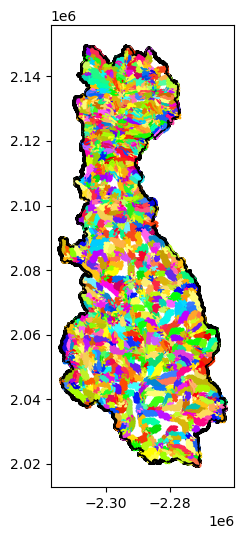

In [21]:
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

    return ax

ax = plot(watershed, rivers)

    

In [22]:
# the outlet here needs to be modified thanks to the coastline reaches

# move the endpoint to the boundary
op = rivers[0].linestring.coords[-1]
cp = shapely.ops.nearest_points(watershed.exterior.exterior, rivers[0].linestring)[0]
print(op, cp)

rivers[0].moveCoordinate(-1, cp)

(-2313566.6413374846, 2045822.3587817412) POINT (-2313594.0474909726 2045820.7559020065)


In [23]:
# prune
rivers = watershed_workflow.reduceRivers(rivers, 
                                         prune_by_area=prune_by_area,
                                         remove_diversions=True,
                                         remove_braided_divergences=True)

for river in rivers:
    river.resetDataFrame()

reduced_reaches = pd.concat([r.df for r in rivers])

2025-10-06 14:43:17,398 - root - INFO: Removing rivers with area < 10
2025-10-06 14:43:17,398 - root - INFO: Removing divergent sections...
2025-10-06 14:43:17,428 - root - INFO:   ... removed 29 divergence tributaries with 37 total reaches.
2025-10-06 14:43:18,034 - root - INFO: ... pruned 948 of 1583


In [24]:
# are all of our gages STILL in our reduced network?
print(sum(sites_10yrs['comid'].isin(reduced_reaches['comid'])), ' of ', len(sites_10yrs), ' are in the set of REDUCED reaches')

23  of  23  are in the set of REDUCED reaches


## Put the gages on the reaches, and use these to define subcatchments

We don't have a good way of splitting the catchment of a reach at the gage's measure of the reach.  If we had this, we could split both the reach and the catchment at the actual gage location, and make subcatchments that respect this.  Let's try to assign the gage to an upstream-most or downstream-most point on the reach instead.



In [25]:
# add another "gage" point -- the outlet of the full domain
assert len(rivers) == 1
sites_10yrs = sites_10yrs.reset_index()

sites = gpd.GeoDataFrame(
    pd.concat([sites_10yrs,
           gpd.GeoDataFrame({'comid' : rivers[0]['comid'],
                             'measure' : 0.,
                             'station_nm' : 'Russian River Outlet',
                             'ID' : 'RR-outlet',
                            },
                            index=[len(sites_10yrs),],
                            geometry=[shapely.geometry.Point(rivers[0].linestring.coords[-1]),],
                            crs=sites_10yrs.crs),
          ]), crs=sites_10yrs.crs)

sites[names.NAME] = sites[names.ID]
sites.pop('index')
sites


,geometry,station_nm,dec_lat_va,dec_long_va,alt_va,alt_acy_va,alt_datum_cd,huc_cd,begin_date,end_date,units,tz,ID,count,comid,measure,name
0,POINT (-2295482.62 2127517.048),"Russian R Nr Ukiah, CA",39.195447,-123.195005,602.25,0.16,NAVD88,18010110,1911-10-01,2022-09-30,mm/day,UTC,USGS-11461000,7200.0,8269099,42.3900,USGS-11461000
1,POINT (-2288554.228 2131447.502),"Ef Russian R Nr Calpella, CA",39.246523,-123.130251,790.74,0.26,NAVD88,18010110,1941-10-01,2025-10-05,mm/day,UTC,USGS-11461500,9410.0,8269091,93.5630,USGS-11461500
2,POINT (-2297109.406 2118353.355),"Russian R Nr Talmage, CA",39.112913,-123.183028,545.95,0.16,NAVD88,18010110,2009-08-06,2025-10-05,mm/day,UTC,USGS-11462080,5905.0,8268521,11.7142,USGS-11462080
3,POINT (-2295520.729 2107795.032),"Russian R Nr Hopland, CA",39.026527,-123.130525,500.01,0.26,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11462500,9410.0,8269119,91.8680,USGS-11462500
4,POINT (-2293821.342 2090102.265),"Russian R Nr Cloverdale, CA",38.879308,-123.053577,374.64,0.16,NAVD88,18010110,1951-08-01,2025-10-05,mm/day,UTC,USGS-11463000,9410.0,8271445,82.7127,USGS-11463000
5,POINT (-2275647.163 2075276.831),"Big Sulphur C A G Resort Nr Cloverdale, CA",38.797645,-122.802458,1429.88,0.16,NAVD88,18010110,1980-10-01,2025-10-05,mm/day,UTC,USGS-11463170,9410.0,8271917,32.4839,USGS-11463170
6,POINT (-2290821.963 2082997.741),"Big Sulphur C Nr Cloverdale, CA",38.825976,-122.996908,302.75,0.16,NAVD88,18010110,1957-07-01,2025-10-05,mm/day,UTC,USGS-11463200,7428.0,8271875,76.1110,USGS-11463200
7,POINT (-2286019.829 2068367.397),"Russian R A Geyserville, CA",38.712645,-122.895792,165.68,0.26,NAVD88,18010110,1910-10-01,2025-10-05,mm/day,UTC,USGS-11463500,4545.0,8272107,28.1658,USGS-11463500
8,POINT (-2282227.758 2060911.556),"Russian R A Jimtown, CA",38.658202,-122.829401,143.70,0.26,NAVD88,18010110,2009-07-01,2025-10-05,mm/day,UTC,USGS-11463682,5276.0,8272211,90.8312,USGS-11463682
9,POINT (-2277336.013 2057484.827),"Maacama C Nr Kellogg, CA",38.640981,-122.763843,179.62,0.16,NAVD88,18010110,1961-01-01,2025-10-05,mm/day,UTC,USGS-11463900,3707.0,8272605,29.5054,USGS-11463900


In [26]:
sites

,geometry,station_nm,dec_lat_va,dec_long_va,alt_va,alt_acy_va,alt_datum_cd,huc_cd,begin_date,end_date,units,tz,ID,count,comid,measure,name
0,POINT (-2295482.62 2127517.048),"Russian R Nr Ukiah, CA",39.195447,-123.195005,602.25,0.16,NAVD88,18010110,1911-10-01,2022-09-30,mm/day,UTC,USGS-11461000,7200.0,8269099,42.3900,USGS-11461000
1,POINT (-2288554.228 2131447.502),"Ef Russian R Nr Calpella, CA",39.246523,-123.130251,790.74,0.26,NAVD88,18010110,1941-10-01,2025-10-05,mm/day,UTC,USGS-11461500,9410.0,8269091,93.5630,USGS-11461500
2,POINT (-2297109.406 2118353.355),"Russian R Nr Talmage, CA",39.112913,-123.183028,545.95,0.16,NAVD88,18010110,2009-08-06,2025-10-05,mm/day,UTC,USGS-11462080,5905.0,8268521,11.7142,USGS-11462080
3,POINT (-2295520.729 2107795.032),"Russian R Nr Hopland, CA",39.026527,-123.130525,500.01,0.26,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11462500,9410.0,8269119,91.8680,USGS-11462500
4,POINT (-2293821.342 2090102.265),"Russian R Nr Cloverdale, CA",38.879308,-123.053577,374.64,0.16,NAVD88,18010110,1951-08-01,2025-10-05,mm/day,UTC,USGS-11463000,9410.0,8271445,82.7127,USGS-11463000
5,POINT (-2275647.163 2075276.831),"Big Sulphur C A G Resort Nr Cloverdale, CA",38.797645,-122.802458,1429.88,0.16,NAVD88,18010110,1980-10-01,2025-10-05,mm/day,UTC,USGS-11463170,9410.0,8271917,32.4839,USGS-11463170
6,POINT (-2290821.963 2082997.741),"Big Sulphur C Nr Cloverdale, CA",38.825976,-122.996908,302.75,0.16,NAVD88,18010110,1957-07-01,2025-10-05,mm/day,UTC,USGS-11463200,7428.0,8271875,76.1110,USGS-11463200
7,POINT (-2286019.829 2068367.397),"Russian R A Geyserville, CA",38.712645,-122.895792,165.68,0.26,NAVD88,18010110,1910-10-01,2025-10-05,mm/day,UTC,USGS-11463500,4545.0,8272107,28.1658,USGS-11463500
8,POINT (-2282227.758 2060911.556),"Russian R A Jimtown, CA",38.658202,-122.829401,143.70,0.26,NAVD88,18010110,2009-07-01,2025-10-05,mm/day,UTC,USGS-11463682,5276.0,8272211,90.8312,USGS-11463682
9,POINT (-2277336.013 2057484.827),"Maacama C Nr Kellogg, CA",38.640981,-122.763843,179.62,0.16,NAVD88,18010110,1961-01-01,2025-10-05,mm/day,UTC,USGS-11463900,3707.0,8272605,29.5054,USGS-11463900


In [27]:
#
# first map from the site locations to the end of the reach we wish to map the gage onto
#
sites['reach_ID'] = sites['comid'].astype(str)
watershed_polys = watershed_workflow.river_tree.determineOutletToReachMap(rivers, sites)



In [28]:
# check that moving to outlets didn't break our set of points?
c1, c2 = checkTooClose(watershed_polys, 'true_geometry')
assert len(c1) == 0
assert len(c2) == 0

Close pairs:
Shared comid:


In [29]:
# now accumluate incremental catchments
watershed_polys = watershed_workflow.river_tree.accumulateIncrementalCatchments(rivers, watershed_polys)
watershed_polys



Computing CA for 23
----------------------------------------
calling trunc_tree on 8272937
stoppping at 8271049
...but including it 8271049
stoppping at 8272725
...but including it 8272725

Computing CA for 21
----------------------------------------
calling trunc_tree on 8272721
stoppping at 8272363
...but including it 8272363
stoppping at 8272379
...but including it 8272379
stoppping at 8273161
...but including it 8273161

Computing CA for 10
----------------------------------------
calling trunc_tree on 8272311
stoppping at 8272211
...but including it 8272211
stoppping at 8272605
...but including it 8272605

Computing CA for 8
----------------------------------------
calling trunc_tree on 8272195
stoppping at 8272107
...but including it 8272107

Computing CA for 7
----------------------------------------
calling trunc_tree on 8272069
stoppping at 8271445
...but including it 8271445
stoppping at 8271875
...but including it 8271875
calling trunc_tree on 8272067

Computing CA for 4
--

,geometry,station_nm,dec_lat_va,dec_long_va,alt_va,alt_acy_va,alt_datum_cd,huc_cd,begin_date,end_date,units,tz,ID,count,comid,measure,name,reach_ID,river_index,reach_index,location_on_reach,true_geometry,incremental_catchment
23,POINT (-2313594.047 2045820.756),Russian River Outlet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RR-outlet,NaN,8272933,0.0000,RR-outlet,8272933,0,0,0,POINT (-2313594.047 2045820.756),"POLYGON ((-2305777.792 2037720.003, -2305971.4..."
21,POINT (-2294250.425 2047087.173),"Russian R A Hacienda Bridge Nr Guerneville, CA",38.508482,-122.927734,22.33,0.16,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11467000,9410.0,8272725,84.0061,USGS-11467000,8272725,0,50,1,POINT (-2295059.53 2047164.785),"POLYGON ((-2295139.405 2029157.058, -2295152.6..."
10,POINT (-2283791.112 2056134.658),"Russian R Nr Healdsburg, CA",38.613203,-122.836345,79.98,0.26,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11464000,9410.0,8272379,89.9621,USGS-11464000,8272379,0,170,1,POINT (-2284208.116 2056234.303),"POLYGON ((-2282306.172 2053923.908, -2282379.5..."
8,POINT (-2282342.202 2061057.323),"Russian R A Jimtown, CA",38.658202,-122.829401,143.70,0.26,NAVD88,18010110,2009-07-01,2025-10-05,mm/day,UTC,USGS-11463682,5276.0,8272211,90.8312,USGS-11463682,8272211,0,187,1,POINT (-2282227.758 2060911.556),"POLYGON ((-2282169.29 2061204.75, -2282340.484..."
7,POINT (-2287482.499 2070478.45),"Russian R A Geyserville, CA",38.712645,-122.895792,165.68,0.26,NAVD88,18010110,1910-10-01,2025-10-05,mm/day,UTC,USGS-11463500,4545.0,8272107,28.1658,USGS-11463500,8272107,0,194,1,POINT (-2286019.829 2068367.397),"POLYGON ((-2290398.307 2071271.746, -2290584.9..."
4,POINT (-2293880.874 2090543.664),"Russian R Nr Cloverdale, CA",38.879308,-123.053577,374.64,0.16,NAVD88,18010110,1951-08-01,2025-10-05,mm/day,UTC,USGS-11463000,9410.0,8271445,82.7127,USGS-11463000,8271445,0,228,1,POINT (-2293821.342 2090102.265),"POLYGON ((-2300428.04 2095381.854, -2300568.90..."
3,POINT (-2295539.859 2108307.778),"Russian R Nr Hopland, CA",39.026527,-123.130525,500.01,0.26,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11462500,9410.0,8269119,91.8680,USGS-11462500,8269119,0,265,1,POINT (-2295520.729 2107795.032),"POLYGON ((-2300338.894 2108398.873, -2300437.1..."
2,POINT (-2297141.368 2118153.588),"Russian R Nr Talmage, CA",39.112913,-123.183028,545.95,0.16,NAVD88,18010110,2009-08-06,2025-10-05,mm/day,UTC,USGS-11462080,5905.0,8268521,11.7142,USGS-11462080,8268521,0,290,0,POINT (-2297109.406 2118353.355),"POLYGON ((-2300908.895 2119921.131, -2301105.0..."
14,POINT (-2287747.214 2054452.235),"Dry C Nr Mouth Nr Healdsburg, CA",38.587370,-122.862178,56.70,0.16,NAVD88,18010110,1981-10-01,2025-10-05,mm/day,UTC,USGS-11465350,7739.0,8272363,2.3004,USGS-11465350,8272363,0,70,1,POINT (-2287155.73 2054074.887),"POLYGON ((-2287719.891 2054198.95, -2287880.08..."
13,POINT (-2290463.565 2062835.084),"Dry C Blw Lambert Br Nr Geyserville, CA",38.653202,-122.927181,112.03,0.16,NAVD88,18010110,2011-11-10,2025-10-05,mm/day,UTC,USGS-11465240,4727.0,8272227,68.2805,USGS-11465240,8272227,0,83,1,POINT (-2290478.701 2062725.744),"POLYGON ((-2292170.937 2062428.575, -2292194.9..."


In [30]:
# remap some of the geometry fields to make life a little simpler
watershed_polys['true_gage_geometry'] = watershed_polys['true_geometry']
watershed_polys['outlet'] = watershed_polys['geometry']
watershed_polys['geometry'] = watershed_polys['incremental_catchment']
watershed_polys = watershed_polys.set_geometry('geometry', crs=watershed_polys.crs)
print(watershed_polys.crs)


EPSG:5070


In [31]:
# one multipolygon?  take the biggest subset...
watershed_polys['geometry'] = [watershed_workflow.split_hucs.findBiggest(p.geoms) if isinstance(p, shapely.geometry.MultiPolygon) else p for p in watershed_polys.geometry]
print(watershed_polys.crs)
watershed_polys


EPSG:5070


,geometry,station_nm,dec_lat_va,dec_long_va,alt_va,alt_acy_va,alt_datum_cd,huc_cd,begin_date,end_date,units,tz,ID,count,comid,measure,name,reach_ID,river_index,reach_index,location_on_reach,true_geometry,incremental_catchment,true_gage_geometry,outlet
23,"POLYGON ((-2305777.792 2037720.003, -2305971.4...",Russian River Outlet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RR-outlet,NaN,8272933,0.0000,RR-outlet,8272933,0,0,0,POINT (-2313594.047 2045820.756),"POLYGON ((-2305777.792 2037720.003, -2305971.4...",POINT (-2313594.047 2045820.756),POINT (-2313594.047 2045820.756)
21,"POLYGON ((-2295139.405 2029157.058, -2295152.6...","Russian R A Hacienda Bridge Nr Guerneville, CA",38.508482,-122.927734,22.33,0.16,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11467000,9410.0,8272725,84.0061,USGS-11467000,8272725,0,50,1,POINT (-2295059.53 2047164.785),"POLYGON ((-2295139.405 2029157.058, -2295152.6...",POINT (-2295059.53 2047164.785),POINT (-2294250.425 2047087.173)
10,"POLYGON ((-2282306.172 2053923.908, -2282379.5...","Russian R Nr Healdsburg, CA",38.613203,-122.836345,79.98,0.26,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11464000,9410.0,8272379,89.9621,USGS-11464000,8272379,0,170,1,POINT (-2284208.116 2056234.303),"POLYGON ((-2282306.172 2053923.908, -2282379.5...",POINT (-2284208.116 2056234.303),POINT (-2283791.112 2056134.658)
8,"POLYGON ((-2282169.29 2061204.75, -2282340.484...","Russian R A Jimtown, CA",38.658202,-122.829401,143.70,0.26,NAVD88,18010110,2009-07-01,2025-10-05,mm/day,UTC,USGS-11463682,5276.0,8272211,90.8312,USGS-11463682,8272211,0,187,1,POINT (-2282227.758 2060911.556),"POLYGON ((-2282169.29 2061204.75, -2282340.484...",POINT (-2282227.758 2060911.556),POINT (-2282342.202 2061057.323)
7,"POLYGON ((-2290398.307 2071271.746, -2290584.9...","Russian R A Geyserville, CA",38.712645,-122.895792,165.68,0.26,NAVD88,18010110,1910-10-01,2025-10-05,mm/day,UTC,USGS-11463500,4545.0,8272107,28.1658,USGS-11463500,8272107,0,194,1,POINT (-2286019.829 2068367.397),"POLYGON ((-2290398.307 2071271.746, -2290584.9...",POINT (-2286019.829 2068367.397),POINT (-2287482.499 2070478.45)
4,"POLYGON ((-2300428.04 2095381.854, -2300568.90...","Russian R Nr Cloverdale, CA",38.879308,-123.053577,374.64,0.16,NAVD88,18010110,1951-08-01,2025-10-05,mm/day,UTC,USGS-11463000,9410.0,8271445,82.7127,USGS-11463000,8271445,0,228,1,POINT (-2293821.342 2090102.265),"POLYGON ((-2300428.04 2095381.854, -2300568.90...",POINT (-2293821.342 2090102.265),POINT (-2293880.874 2090543.664)
3,"POLYGON ((-2300338.894 2108398.873, -2300437.1...","Russian R Nr Hopland, CA",39.026527,-123.130525,500.01,0.26,NAVD88,18010110,1939-10-01,2025-10-05,mm/day,UTC,USGS-11462500,9410.0,8269119,91.8680,USGS-11462500,8269119,0,265,1,POINT (-2295520.729 2107795.032),"POLYGON ((-2300338.894 2108398.873, -2300437.1...",POINT (-2295520.729 2107795.032),POINT (-2295539.859 2108307.778)
2,"POLYGON ((-2300908.895 2119921.131, -2301105.0...","Russian R Nr Talmage, CA",39.112913,-123.183028,545.95,0.16,NAVD88,18010110,2009-08-06,2025-10-05,mm/day,UTC,USGS-11462080,5905.0,8268521,11.7142,USGS-11462080,8268521,0,290,0,POINT (-2297109.406 2118353.355),"POLYGON ((-2300908.895 2119921.131, -2301105.0...",POINT (-2297109.406 2118353.355),POINT (-2297141.368 2118153.588)
14,"POLYGON ((-2287719.891 2054198.95, -2287880.08...","Dry C Nr Mouth Nr Healdsburg, CA",38.587370,-122.862178,56.70,0.16,NAVD88,18010110,1981-10-01,2025-10-05,mm/day,UTC,USGS-11465350,7739.0,8272363,2.3004,USGS-11465350,8272363,0,70,1,POINT (-2287155.73 2054074.887),"POLYGON ((-2287719.891 2054198.95, -2287880.08...",POINT (-2287155.73 2054074.887),POINT (-2287747.214 2054452.235)
13,"POLYGON ((-2292170.937 2062428.575, -2292194.9...","Dry C Blw Lambert Br Nr Geyserville, CA",38.653202,-122.927181,112.03,0.16,NAVD88,18010110,2011-11-10,2025-10-05,mm/day,UTC,USGS-11465240,4727.0,8272227,68.2805,USGS-11465240,8272227,0,83,1,POINT (-2290478.701 2062725.744),"POLYGON ((-2292170.937 2062428.575, -2292194.9...",POINT (-229

In [32]:
# all area > 0?
print(watershed_polys.area)
assert min(watershed_polys.area) > 0.
print(len(watershed_polys))
print(len(sites))

23    2.244253e+08
21    2.118484e+08
10    1.701094e+08
8     8.143825e+07
7     1.743512e+08
4     3.617881e+08
3     1.965240e+08
2     2.444139e+08
14    9.719951e+07
13    2.983142e+07
20    2.501367e+08
12    8.217599e+07
11    3.378694e+08
0     2.588431e+08
1     2.386050e+08
6     1.907015e+08
16    1.029694e+08
19    4.813443e+07
22    1.614908e+08
18    8.744712e+07
15    1.059992e+08
9     1.102009e+08
17    5.698729e+07
5     2.225511e+07
dtype: float64
24
24


In [33]:
for i, geo_i in enumerate(watershed_polys.geometry):
    for j, geo_j in enumerate(watershed_polys.geometry):
        if j > i:
            if geo_i.contains(geo_j):
                print(f"CONTAINS: {watershed_polys.index[i]} comid {watershed_polys.iloc[i]['comid']} contains {watershed_polys.index[j]} comid {watershed_polys.iloc[j]['comid']}")            
            if geo_j.contains(geo_i):
                print(f"CONTAINS: {watershed_polys.index[j]} comid {watershed_polys.iloc[j]['comid']} contains {watershed_polys.index[i]} comid {watershed_polys.iloc[i]['comid']}")            

            area = geo_i.intersection(geo_j).area
            af_i = area / geo_i.area
            af_j = area / geo_j.area
            if af_i > .01 or af_j > .01:
                print('large intersection:', watershed_polys.index[i], watershed_polys.index[j], 'area_frac =', af_i, af_j)

In [34]:
# save these shapefiles to disk
watershed_polys.to_parquet(toOutput('watershed_polys', '01_watershed_polys.parquet'))

river_df = gpd.GeoDataFrame(pd.concat([r.to_dataframe() for r in rivers]), crs=crs)
river_df.to_parquet(toOutput('rivers', '01_rivers.parquet'))

qobs.to_csv(toOutput('evaluation_discharge', '01_discharge_observations.csv'))


In [35]:
# save output filenames
with open(toOutput('04_output_filenames', '01_output_filenames.txt'), 'wb') as fid:
    pickle.dump(output_filenames, fid)